In [1]:
import sys
sys.path.append("../")
import os
import pickle as pkl
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
import math

from coh_tools import *

In [2]:
repo_dir = "C:/Users/julienb/lab/opto_data_analysis"
data_dir = "C:/Users/julienb/lab/data"
#repo_dir = "/home/julien/school/lab/opto_data_analysis"
#data_dir = "/mnt/hdd2tb/lab/elife/data"
    
only_paired=False
skip_short=True
skip_single_stim=True

experiments = pd.read_csv(repo_dir+'/csvs/table_of_experiments.csv')
experiments['keyname'] = experiments['File Name'].str[:-4]


multiband_allcon_dict = pkl.load(open(data_dir+"/pickled/multiband_timefreq_allcon_dict.pkl", "rb"))
multiband_allcon_phase_dict = pkl.load(open(data_dir+"/pickled/multiband_timefreq_allcon_phase_dict.pkl", "rb"))

ecog_map = map_to_ecog(np.arange(1, 97), want_data=True, csv_dir = repo_dir+"/csvs/")

m1_data = pd.read_csv(repo_dir+'/csvs/M1_sites.csv')
s1_data = pd.read_csv(repo_dir+'/csvs/S1_sites.csv')

def get_distance(electrode_a, electrode_b): # Indexing is 1 - 96
    if min(electrode_a, electrode_b) <= 0:
#         print("Electrode indexing starts from 1")
#         return
        return 0
    return ((ecog_map[0][electrode_a-1]  - ecog_map[0][electrode_b-1])**2 + (ecog_map[1][electrode_a-1]  - ecog_map[1][electrode_b-1])**2)**.5

# Flattens same way as np flatten()
def get_distances_multi(electrode_list_a, electrode_list_b=[]):
    electrode_list_b = np.array(electrode_list_b).astype(int)
    electrode_list_a = np.array(electrode_list_a).astype(int)
    if not electrode_list_b.any():
        electrode_list_b = electrode_list_a
    distances = []
    for electrode_a in electrode_list_a:
        for electrode_b in electrode_list_b:
            distances.append(get_distance(electrode_a, electrode_b))
    return distances
    # still need to implement unflattened

    def concatenator(lists):
        new_lists = []
        for list_ind in lists:
            new_lists.append(np.asarray(np.concatenate(list_ind)).flatten())
        return new_lists

good_channels = pkl.load(open(repo_dir+"/pickled/good_channels.pkl", "rb"))

## Generate dataframe
dataframes = {}
for band in ["theta"]:
    print(band)

    data_dict = multiband_allcon_dict[band]
    phase_dict = multiband_allcon_phase_dict[band]
    from_electrodes = []
    to_electrodes = []
    stim_froms = []
    stim_tos = []
    phasemeans = []

    condmeans = []
    basemeans = []
    newbasemeans = []
    cond_sds = []
    base_sds = []

    delays = []
    deltacohs = []
    distances = []
    num_lasers = []
    coherence_projections = []

    coherence_projections_sd = []

    coherence_diff_mag = []
    coherence_diff_mag_sd = []
    coherence_sum_mag = []
    coherence_sum_mag_sd = []
    
    block_nums = []
    distances_to_a1 = []
    distances_to_b1 = []
    distances_to_a2 = []
    distances_to_b2 = []
    experiment_block_keys = []
    pc1a_mean = []
    pc2a_mean = []
    pc1b_mean = []
    pc2b_mean = []
    pc1a_sd = []
    pc2a_sd = []
    pc1b_sd = []
    pc2b_sd = []
    monkeys = []
    both_m1 = []
    both_s1 = []
    in_upper_triangle = []
    on_diagonal = []
    
    avg_pair_net_coh = []
    avg_pair_net_coh_sd = []

    # Iterate through experiments
    for index, row in experiments.iterrows():
        key = row["keyname"]
        exp_num_laser = int(row["Number of Lasers during Conditioning"])
#             if (exp_num_laser == 0 or (row["stim_Coh_from"] == 0 and row["stim_Coh_to"] == 0)):
        if skip_single_stim:
            if (exp_num_laser <= 1 or (row["stim_Coh_from"] == 0 or row["stim_Coh_to"] == 0)):
                continue
                        
        exp_good_channels = good_channels[key[:-3]]
        
        
        distancelist = get_distances_multi(exp_good_channels)
        from_electrode_list = np.tile(np.array(exp_good_channels), [len(exp_good_channels),1]).T.flatten()
        to_electrode_list = np.tile(np.array(exp_good_channels), [len(exp_good_channels),1]).flatten()
        stim_from_list = (np.ones((len(exp_good_channels), len(exp_good_channels)))*row["stim_Coh_from"]).flatten()
        stim_to_list = (np.ones((len(exp_good_channels), len(exp_good_channels)))*row["stim_Coh_to"]).flatten()
        a_list = np.ones(len(exp_good_channels)) * int(row["stim_Coh_from"])
        b_list = np.ones(len(exp_good_channels)) * int(row["stim_Coh_to"])
        distance_to_a1_list = get_distances_multi(exp_good_channels, a_list)
        distance_to_b1_list = get_distances_multi(exp_good_channels, b_list)
        distance_to_a2_list = get_distances_multi(a_list, exp_good_channels)
        distance_to_b2_list = get_distances_multi(b_list, exp_good_channels)
        monkey_list = [key[6]]*len(distancelist)
        exp_num_laser_list = np.ones(len(distancelist)) * exp_num_laser
        m1_exp_data, s1_exp_data = get_m1_s1_matrices(m1_data, s1_data, good_channels, key[:-3])
        
        on_diagonal_list = np.eye(len(exp_good_channels)).flatten()
        in_upper_triangle_list = np.triu(np.ones(len(exp_good_channels)), 1).flatten()

        try:
            exp_delay_list = np.ones(len(distancelist)) * int(row["Delay"][:-2])
        except:
            exp_delay_list = np.zeros(len(distancelist))

        for block_num in np.arange(6)+1:
            rec_key = key+"_RecBlock"+str(block_num)
            stim_key = key+"_CondBlock"+str(block_num)
            if block_num < 6:
                block_base_data = data_dict[rec_key]
                block_base_data_means = block_base_data.mean(0)

                if skip_short:
                    if block_base_data.shape[0] == 1:
                        break

                basemeans.append(block_base_data_means.flatten())
                phasemeans.append(np.abs(phase_dict[rec_key].mean(0).flatten()))
                condmeans.append(data_dict[stim_key].mean(0).flatten())


                base_sds.append(block_base_data.std(0).flatten())
                cond_sds.append(data_dict[stim_key].std(0).flatten())

                coherence_projections.append((np.dot(block_base_data_means, block_base_data_means)/block_base_data_means.shape[0]).flatten())
                coherence_projections_sd.append(np.asarray([np.dot(base_data, base_data) for base_data in block_base_data]).std(0).flatten())
                coherence_diff_mag.append(get_coh_diff_mag(block_base_data_means).flatten())
                coherence_sum_mag.append(get_coh_sum_mag(block_base_data_means).flatten())
                
                avg_pair_net_coh.append(get_pair_net_coh(block_base_data_means).flatten())
                avg_pair_net_coh_sd.append(np.asarray([get_pair_net_coh(base_data) for base_data in block_base_data]).std(0).flatten())
                
                #avg_graph_net_coh.append(block_base_data_means.mean()*np.ones(len(distancelist)))
                #avg_graph_net_coh_sd.append(block_base_data.mean(1).mean(1).std()*np.ones(len(distancelist))) 
                
                coherence_diff_mag_sd.append(np.asarray([get_coh_diff_mag(base_data) for base_data in block_base_data]).std(0).flatten())
                coherence_sum_mag_sd.append(np.asarray([get_coh_sum_mag(base_data) for base_data in block_base_data]).std(0).flatten())
                
                distances.append(distancelist)
                distances_to_a1.append(distance_to_a1_list)
                distances_to_b1.append(distance_to_b1_list)
                distances_to_a2.append(distance_to_a2_list)
                distances_to_b2.append(distance_to_b2_list)
                num_lasers.append(exp_num_laser_list)
                delays.append(exp_delay_list)
                block_nums.append(block_num*np.ones(len(distancelist)))
                experiment_block_keys.append([stim_key[:-12]]*len(distancelist))
                both_m1.append(m1_exp_data.flatten())
                both_s1.append(s1_exp_data.flatten())
                stim_froms.append(stim_from_list)
                stim_tos.append(stim_to_list)
                from_electrodes.append(from_electrode_list)
                to_electrodes.append(to_electrode_list)

                if block_num == 1:
                    scaler = StandardScaler()
                    scaled_base = scaler.fit_transform(np.vstack(data_dict[rec_key]))
                    pca = PCA(n_components=2)
                    pca.fit(scaled_base)
                    
                    
                pca_mean_data = pca.transform(scaler.transform(block_base_data_means))
                pc1a_mean.append(np.repeat(pca_mean_data[:, 0], pca_mean_data.shape[0]))
                pc2a_mean.append(np.repeat(pca_mean_data[:, 1], pca_mean_data.shape[0]))
                pc1b_mean.append(np.tile(pca_mean_data[:, 0], pca_mean_data.shape[0]))
                pc2b_mean.append(np.tile(pca_mean_data[:, 1], pca_mean_data.shape[0]))

                pca_sd_data = np.asarray([pca.transform(scaler.transform(sd_vec)) for sd_vec in data_dict[rec_key]]).std(0)
                pc1a_sd.append(np.repeat(pca_sd_data[:, 0], pca_sd_data.shape[0]))
                pc2a_sd.append(np.repeat(pca_sd_data[:, 1], pca_sd_data.shape[0]))
                pc1b_sd.append(np.tile(pca_sd_data[:, 0], pca_sd_data.shape[0]))
                pc2b_sd.append(np.tile(pca_sd_data[:, 1], pca_sd_data.shape[0]))

theta


KeyboardInterrupt: 

In [22]:
block_base_data_means.shape

(87, 87)

In [23]:
block_base_data_means.mean()**3

0.2683654309318571

In [19]:
cc = 0
for i in range(block_base_data_means.shape[0]):
    for j in range(block_base_data_means.shape[0]):
        cc += np.mean(block_base_data_means[i] * block_base_data_means[j] * block_base_data_means[i,j])

In [20]:
cc

2186.6900685170135

In [21]:
cc/(87**2)

0.2889007885476303

In [11]:
import seaborn as sns

C:\Users\julienb\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


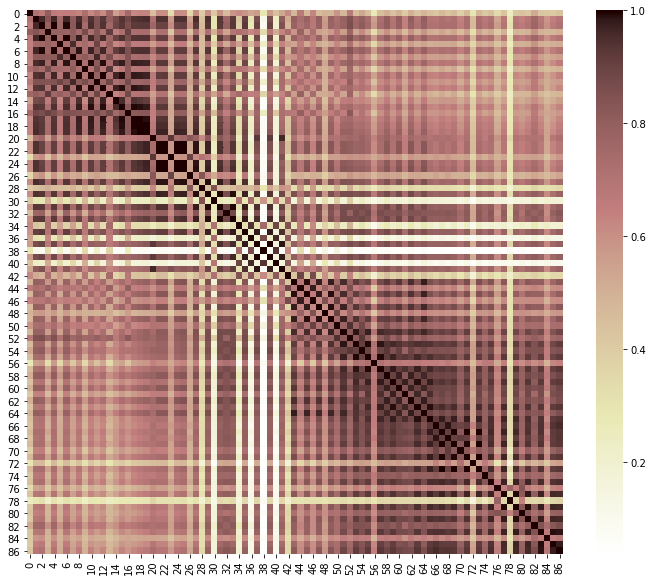

In [25]:
plt.figure(figsize=[12,10])
sns.heatmap(block_base_data[0], cmap="pink_r")
plt.savefig("coh_heatmap.pdf")

In [4]:
np.asarray([get_coh_diff_mag(base_data) for base_data in block_base_data]).std(0).flatten()

array([0.        , 0.02287444, 0.02410325, ..., 0.01428254, 0.0172369 ,
       0.        ])

In [7]:
block_base_data.shape

(15, 52, 52)

In [8]:
block_base_data_means.shape

(52, 52)

In [9]:
np.cov(block_base_data)

ValueError: m has more than 2 dimensions

In [10]:
t = [np.cov(block) for block in block_base_data]

In [14]:
np.asarray(t).mean(0).shape

(52, 52)

In [15]:
def get_coh_cov_time(mt):
    cov_t = np.zeros(mt.shape[1:])
    for i in range(mt.shape[0]):
        for j in range(i):
            time_cov = [np.cov(mt[time, i], mt[time, j]) for time in range(mt.shape[0])]
            cov_t[i, j] = np.asarray(time_cov).mean(0)
            cov_t[j, i] = cov_t[i, j]
    return cov_t



In [16]:
get_coh_cov_time(block_base_data)

ValueError: setting an array element with a sequence.

In [17]:
mt = block_base_data

cov_t = np.zeros(mt.shape)
for i in range(mt.shape[0]):
    for j in range(i):
        
        
        time_cov = [np.cov(mt[time, i], mt[time, j]) for time in range(mt.shape[0])]
        cov_t[i, j] = np.asarray(time_cov).mean(0)
        cov_t[j, i] = cov_t[i, j]

ValueError: setting an array element with a sequence.

In [23]:
[np.cov(mt[time, i], mt[time, j]) for time in range(mt.shape[0])]

[array([[ 0.01840086, -0.00419317],
        [-0.00419317,  0.04192713]]), array([[0.01768938, 0.00365408],
        [0.00365408, 0.04931037]]), array([[0.02113147, 0.01125654],
        [0.01125654, 0.06935002]]), array([[0.02136287, 0.00622014],
        [0.00622014, 0.04510206]]), array([[0.02295396, 0.0048408 ],
        [0.0048408 , 0.04343256]]), array([[0.01872717, 0.00213609],
        [0.00213609, 0.04743363]]), array([[0.02134224, 0.00162029],
        [0.00162029, 0.04571079]]), array([[ 0.02511175, -0.00293867],
        [-0.00293867,  0.05347986]]), array([[0.02558181, 0.00495381],
        [0.00495381, 0.04792197]]), array([[ 0.01962075, -0.00251401],
        [-0.00251401,  0.04564634]]), array([[0.01869093, 0.00542642],
        [0.00542642, 0.03917654]]), array([[0.01989814, 0.0057937 ],
        [0.0057937 , 0.04382333]]), array([[0.01870703, 0.00035322],
        [0.00035322, 0.04522784]]), array([[0.01956707, 0.00891505],
        [0.00891505, 0.04693684]]), array([[0.02007776, 0

In [27]:
np.cov(mt[1, 2].T, mt[1, 3].T)

array([[0.03096178, 0.01222069],
       [0.01222069, 0.03218176]])

In [26]:
mt[1, 2]

array([0.25793732, 0.1520929 , 1.        , 0.18035018, 0.55512158,
       0.41530303, 0.44992693, 0.3087039 , 0.15566951, 0.43260577,
       0.31515969, 0.23060068, 0.55633921, 0.43292629, 0.07024142,
       0.27980721, 0.18069483, 0.28804828, 0.28851237, 0.44355597,
       0.28133208, 0.07900701, 0.22186138, 0.0404837 , 0.1250895 ,
       0.04729107, 0.15140232, 0.24280901, 0.1293005 , 0.22065296,
       0.0978736 , 0.11460124, 0.15420398, 0.22619818, 0.128369  ,
       0.20500974, 0.14650422, 0.05580766, 0.03296423, 0.29394201,
       0.02914403, 0.05790582, 0.21351449, 0.04453429, 0.18443749,
       0.11797261, 0.213794  , 0.0751216 , 0.04465419, 0.04113472,
       0.03356181, 0.14574803])

In [28]:
mt[:,2,:].shape

(15, 52)

In [30]:
np.cov(mt[:,2,:].T).shape

(52, 52)

In [38]:
t = np.asarray([np.cov(mt[:,:,elec].T) for elec in range(mt.shape[-1])])

In [42]:
t.mean(0).shape

(52, 52)